<a href="https://colab.research.google.com/github/PetrovAlexey/Visualization/blob/main/LabelTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib python-sat    
!for i in `seq 1 6`; do wget https://github.com/PetrovAlexey/Visualization/raw/main/Examples/hard$i.txt; done
!wget https://github.com/PetrovAlexey/Visualization/raw/main/Examples/bricks.txt
!wget https://github.com/PetrovAlexey/Visualization/raw/main/Examples/frame.txt

--2021-04-24 20:05:56--  https://github.com/PetrovAlexey/Visualization/raw/main/Examples/hard1.txt
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PetrovAlexey/Visualization/main/Examples/hard1.txt [following]
--2021-04-24 20:05:57--  https://raw.githubusercontent.com/PetrovAlexey/Visualization/main/Examples/hard1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 894 [text/plain]
Saving to: ‘hard1.txt.3’

hard1.txt.3         100%[===================>]     894  --.-KB/s    in 0s      

2021-04-24 20:05:57 (18.6 MB/s) - ‘hard1.txt.3’ saved [894/894]

--2021-04-24 20:05:57--  https://github.c

In [2]:
import re
from pysat.solvers import Solver
from matplotlib import patches
from matplotlib import pyplot as plt

In [3]:
def parseData(data):
  id = 1
  points = []
  rects = []
  for row in data:
    point_coords, rect_sizes, offsets = re.split(r"\s+", row, maxsplit=2)
    point_x, point_y = parsePair(point_coords)
    point = {(point_x, point_y): []}
    width, height = parsePair(rect_sizes)

    for offset_x, offset_y in (parsePair(offset) for offset in offsets.split(" ")):
      rect_x = point_x - offset_x
      rect_y = point_y - offset_y

      # Валидация данных
      if rect_x < 0 or rect_y < 0:
        continue
      if rect_x + width > 500 or rect_y + height > 500:
        continue

      # Кодируем прямоугольник
      rect = (rect_x, rect_y, width, height, id, (point_x, point_y))
      id += 1
      
      point[(point_x, point_y)].append(rect)
      rects.append(rect)
    points.append(point)
  return points, rects

def parsePair(pair_str, separator=","):
  x, y = tuple(map(int, pair_str.split(separator)))
  return (x, y)

In [4]:
def intersection(rect1, rect2):
        left_rect, right_rect = (rect1, rect2) if rect1[0] < rect2[0] else (rect2, rect1)
        up_rect, down_rect = (rect1, rect2) if rect1[1] < rect2[1] else (rect2, rect1)

        if (left_rect[0] <= right_rect[0] <= left_rect[0] + left_rect[2] and up_rect[1] <= down_rect[1] <= up_rect[1] + up_rect[3]):
            return True
        return False

def initConflicts(rects):
  conflicts = {}
  for rect1 in rects:
    for rect2 in rects:
      if rect1[5] == rect2[5]:
        continue

      if intersection(rect1, rect2):
        if rect1[4] not in conflicts:
          conflicts[rect1[4]] = set()
        conflicts[rect1[4]].add(rect2[4])
  return conflicts

def rectLayer(rects, points):
  rectsDict = {rect[4]: rect for rect in rects}
  conflicts = initConflicts(rects)
  with Solver(name="mc") as solver:
    for point in points:
      rects_ids = [rect[4] for rect in next(iter(point.values()))]
      solver.add_atmost(rects_ids, 1)
      solver.add_clause(rects_ids)
    for rect in rects:
      if rect[4] in conflicts:
        for confId in conflicts[rect[4]]:
          solver.add_clause([-rect[4], -confId])
    if solver.solve():
      ids = solver.get_model()
      return [rectsDict[idx] for idx in ids if idx > 0]
    else:
      print("Решение отсутствует!")
      raise

In [5]:
def draw_labels(rects, points, label="test"):
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter_x = [p[0] for p in points]
    scatter_y = [p[1] for p in points]
    ax.set_title(label)
    ax.scatter(scatter_x, scatter_y, color='green')
    patch_rects = [patches.Rectangle(xy=(rect[0], rect[1]), width=rect[2], height=rect[3], alpha=0.3) for i, rect in enumerate(rects)]
    for patch_rect in patch_rects:
        ax.add_patch(patch_rect)
    plt.show()

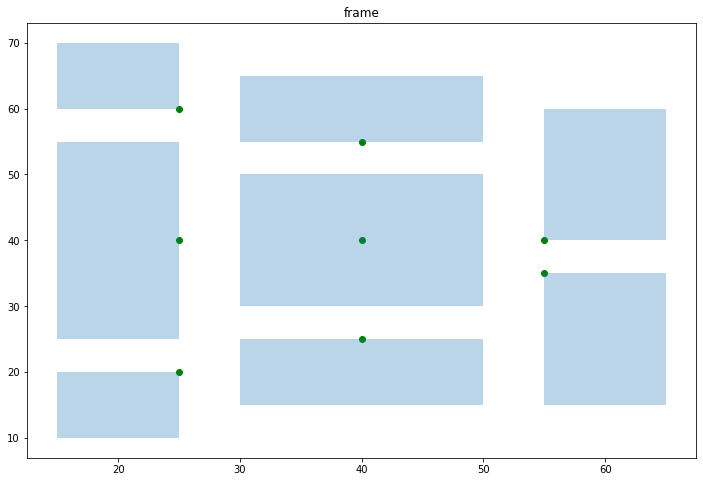

In [6]:
with open(f"./frame.txt", "r") as rows:
    all_points, all_rects = parseData(rows)
    result_rects = rectLayer(all_rects, all_points)
    draw_labels(result_rects, [next(iter(point.keys())) for point in all_points], "frame")

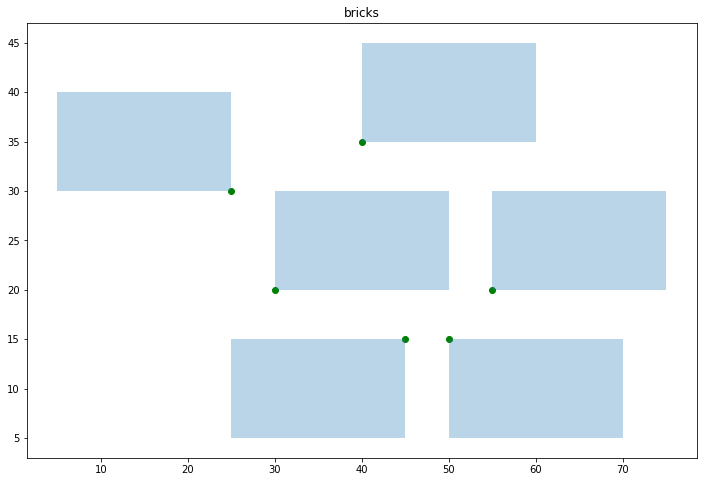

In [7]:
with open(f"./bricks.txt", "r") as rows:
    all_points, all_rects = parseData(rows)
    result_rects = rectLayer(all_rects, all_points)
    draw_labels(result_rects, [next(iter(point.keys())) for point in all_points], "bricks")

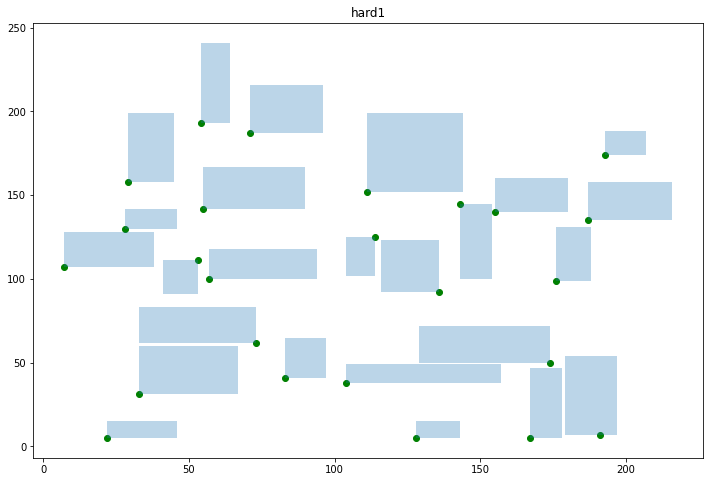

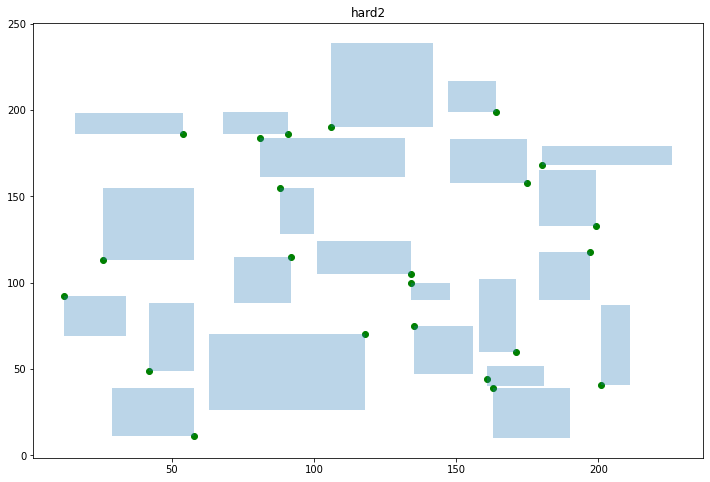

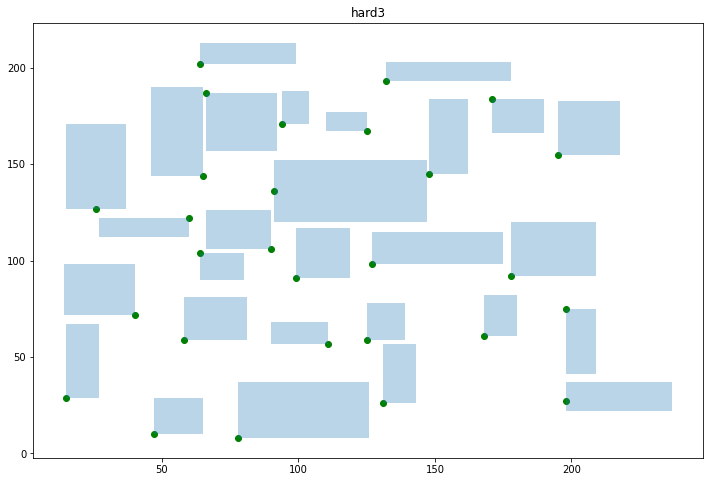

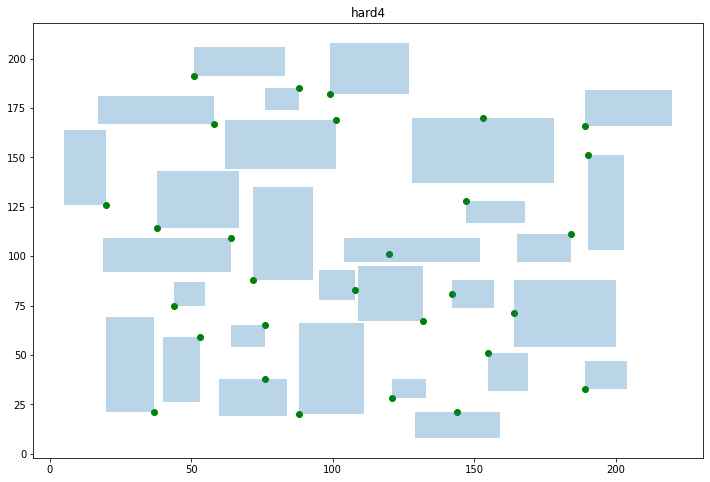

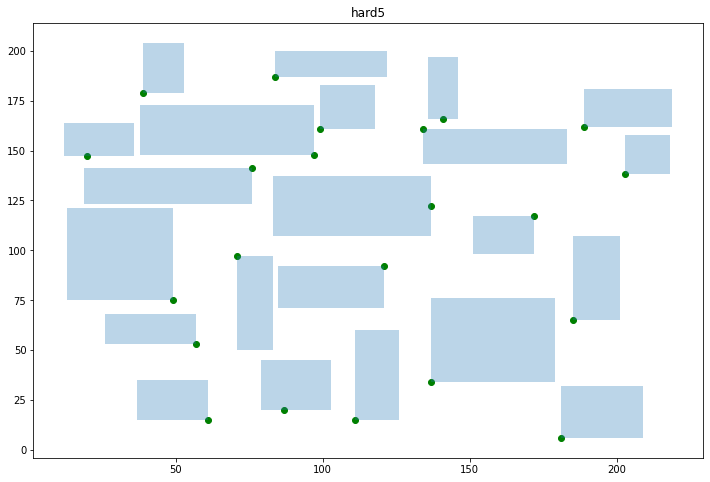

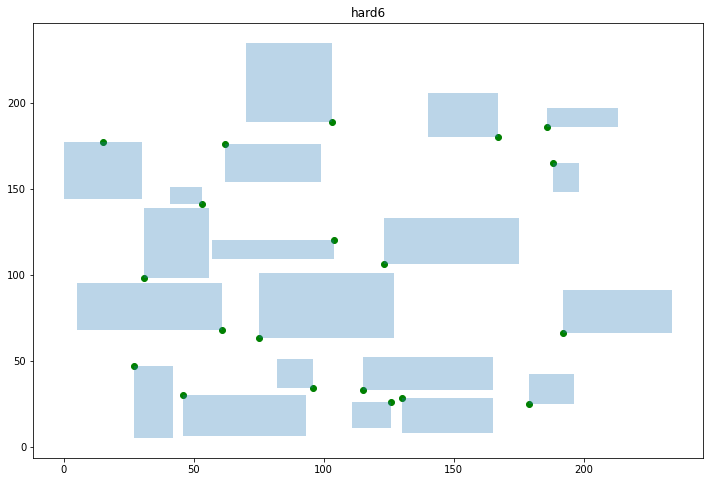

In [8]:
for i in range(1, 7):
  with open(f"./hard{i}.txt", "r") as rows:
    all_points, all_rects = parseData(rows)
    result_rects = rectLayer(all_rects, all_points)
    draw_labels(result_rects, [next(iter(point.keys())) for point in all_points], f"hard{i}")